# Race analysis

### Kyle Willett ([@willettk](https://github.com/willettk))

Some time-wasting ways of filtering and sorting my personal data from running races. 

In [1]:
# Get them packages

import pandas as pd
import datetime
import re
import numpy as np
from collections import Counter
from IPython.display import display

In [2]:
# Running data comes from Github-hosted website

url = "http://willettk.github.io/racelist.html"

In [3]:
# Load into Pandas dataframes

races = pd.read_html(url,parse_dates=True)

run = races[0]
# Rename columns for some easier typing
rc = run.columns
run.rename(columns={rc[0]:"date",
                    rc[1]:"race",
                    rc[2]:"d_km",
                    rc[3]:"d_mi",
                    rc[4]:"location",
                    rc[5]:"time",
                    rc[6]:"pace",
                    rc[7]:"place_overall",
                    rc[8]:"finishers_overall",
                    rc[9]:"place_division",
                    rc[10]:"finishers_division",
                    rc[11]:"division"
                   },inplace=True)

# Ditch the couple races where finishing data
# is probably inaccurate, based on lack of pace
run = run[[False if type(x) == float and np.isnan(x) else True for x in run.pace]]

In [4]:
def filter_races(distance):

    # Filter for races at a given distance (rounded to nearest tenth of a mile)
    
    run_columns = ['date','race','location','time','pace','place_overall','finishers_overall','place_division','finishers_division']
    dt = run[run['d_mi'].round(1) == distance][run_columns]

    try:
        dt['date'] = pd.to_datetime(dt.date)
    except AttributeError:
        print(dt)
    dt['pace'] = [datetime.timedelta(minutes=float(x.split()[0].split(':')[0]),
                                         seconds=float(x.split()[0].split(':')[1])) for x in dt.pace]
    try:
        dt['time'] = [datetime.timedelta(hours=float(x.split(':')[0]),
                                         minutes=float(x.split(':')[1]),
                                         seconds=float(x.split(':')[2])) for x in dt.time]
    except IndexError:
        dt['time'] = [datetime.timedelta(minutes=float(x.split(':')[0]),
                                     seconds=float(x.split(':')[1])) for x in dt.time]


    # Restrict to races with data on overall and division placing,
    # in case you want to analyze relative performace
    dtf = dt[np.isfinite(dt['finishers_overall']) & np.isfinite(dt['finishers_division'])].copy()
    for c in dtf.columns[-4:]:
        dtf[c] = dtf[c].astype(int)
    
    return dt,dtf

In [5]:
def distinct_places(df):
    # Find distinct states/polities for a set of races
    return Counter([l.split(",")[-1].strip() for l in df.location])

In [6]:
def more_than_once(df):
    # Find races run more than once
    c = Counter(df.race)
    races,count = [],[]
    for r in c:
        if c[r] > 1:
            races.append(r)
            count.append(c[r])
    
    return pd.DataFrame({'race':races},index=count).sort_index(ascending=False)

In [7]:
def time_formatting(t,verbose=False):
    # Output times in something sensibly human-readable
    if t.seconds > 3600:
        if verbose:
            print("Formatting as HH:MM:SS")
        timestr = "{:.0f}:{:02.0f}:{:02.0f}".format(int(t.seconds / 3600), int((t.seconds % 3600)/60), t.seconds % 60 )
    elif t.seconds > 60:
        if verbose:
            print("Formatting as MM:SS")
        timestr = "{:.0f}:{:02.0f}".format(int(t.seconds / 60), t.seconds % 60 )
    else:
        if verbose:
            print("Formatting as SS")
        timestr = "{:.0f}".format(t.seconds)

    return timestr

In [8]:
def personal_best(df):
    # Return personal best time at a given distance
    best = df.sort_values("time").reset_index().loc[0]
    timestr = time_formatting(best.time)

    race = best.race
    year = best.date.year
    d = {'time':timestr,'race':race,'year':year}
    
    return d

In [9]:
def summarize(distance):
    # Print out everything prettily
    dt,dtf = filter_races(distance) 
    n = len(dt)
    print("\nI've run {} race{} of {} mile{}.\n".format(n,"" if n == 1 else "s",distance,"" if int(distance) == 1 else "s"))
    print("Personal best: {time}, set at {race} in {year}.\n".format(**personal_best(dt)))
    print("I've run this distance in {}.\n".format(re.sub("['\[\]]","",str(["{} ({})".format(x[0],x[1]) for x in distinct_places(dt).items()]))))
    print("Races of {} mile{} that I've run more than once:".format(distance,"" if int(distance) == 1 else "s"))
    #display(dt)
    display(more_than_once(dt))

### For a given distance, summarize:

* number of races
* locations
* personal best
* races run more than once

In [10]:
# Only summarize the N most common distances
nd = 6

mcd = [round(float(x[0]),1) for x in Counter(run['d_mi']).most_common(nd)]
mcd.sort()
for d in mcd:
    summarize(d)


I've run 27 races of 3.1 miles.

Personal best: 18:09, set at Run for the Horses in 2016.

I've run this distance in KY (5), MN (18), CO (3), CT (1).

Races of 3.1 miles that I've run more than once:


,race
3,Victory 5K
3,Run for the Roses
2,Highland Fest River Run
2,Frigid 5
2,The Human Race



I've run 25 races of 6.2 miles.

Personal best: 38:18, set at Get in Gear in 2016.

I've run this distance in United Kingdom (1), KY (1), MN (19), CO (2), WA (2).

Races of 6.2 miles that I've run more than once:


,race
10,Get in Gear
6,Victory 10K
2,Bolder Boulder



I've run 10 races of 10.0 miles.

Personal best: 1:02:37, set at TC 10 Mile in 2012.

I've run this distance in MN (7), CO (1), WA (2).

Races of 10.0 miles that I've run more than once:


,race
3,TC 10 Mile
2,Bridle Trails Winter Running Festival



I've run 32 races of 13.1 miles.

Personal best: 1:22:35, set at Skagit Flats Half Marathon in 2017.

I've run this distance in CO (6), WA (5), MN (16), Ireland (1), IA (1), KY (1), FL (1), WY (1).

Races of 13.1 miles that I've run more than once:


,race
4,Mora Half Marathon
2,New Prague Half Marathon
2,Minnesota Half Marathon
2,Half Fast Half Marathon



I've run 9 races of 15.5 miles.

Personal best: 1:43:31, set at Ron Daws 25K in 2016.

I've run this distance in MN (5), CO (2), WA (1), TX (1).

Races of 15.5 miles that I've run more than once:


,race
3,Afton Trail Run
2,Greenland Trail Races



I've run 9 races of 26.2 miles.

Personal best: 2:56:33, set at Lake Wobegon Trail Marathon in 2016.

I've run this distance in MA (1), MN (4), CO (3), PA (1).

Races of 26.2 miles that I've run more than once:


,race


### How has my personal best for each distance progressed?

In [11]:
def personal_best_progression(distance=13.1):
    
    # In ascending chronological order for a given distance,
    # print out all races which set or equalled a previous personal best time.
    
    dt,dtf = filter_races(distance) 
    n = len(dt)
    if n > 0:
        firstrace = dt.iloc[0]
        best = firstrace.time
        bestyear = firstrace.date.year
        timestr = time_formatting(firstrace.time)
        print("Personal best progression of {} miles ({} race{}):\n".format(distance,n,"" if n == 1 else "s"))
        print("\tFirst run {}: {} at {}.".format(firstrace.date.year,timestr,firstrace.race))
        for i in range(n-1):
            row = dt.iloc[i+1]
            if row.time <= best:
                timestr_new = time_formatting(row.time)
                print("\tNew PB in {}: {} at {}.".format(row.date.year,timestr_new,row.race,))
                best = row.time
    else:
        print("No races found for distance of {} miles.".format(distance))

    return None

In [12]:
# Example of progression of personal bests
personal_best_progression(13.1)

Personal best progression of 13.1 miles (32 races):

	First run 2001: 1:41:18 at Mora Half Marathon.
	New PB in 2007: 1:32:49 at Georgetown to Idaho Springs Half Marathon.
	New PB in 2008: 1:31:54 at Apple Blossom Races.
	New PB in 2008: 1:30:52 at American Discovery Trail Half Marathon.
	New PB in 2008: 1:28:02 at Heart Center of the Rockies Half Marathon.
	New PB in 2009: 1:27:53 at Indian Summer Half Marathon.
	New PB in 2010: 1:27:07 at Minnesota Half Marathon.
	New PB in 2013: 1:25:49 at Half Fast Half Marathon.
	New PB in 2017: 1:22:35 at Skagit Flats Half Marathon.


### How have I done, year over year, in setting personal bests?

In [13]:
# Only consider PBs at the most common/iconic distances. 
distances = {1:"1 mile",3.1:"5 km",6.2:"10 km",13.1:"half marathon",26.2:"marathon"}
distances_rev = {v:k for k,v in distances.items()}

In [14]:
# Find range of years of active running
pb = {}
start_year = pd.to_datetime(run.iloc[0].date).year
this_year = datetime.datetime.now().year
for year in range(start_year,this_year+1):
    pb[year] = []

# Append if a PB is set for any of the selected distances
for distance in distances.keys():
    dt,dtf = filter_races(distance) 
    n = len(dt)
    if n > 0:
        firstrace = dt.iloc[0]
        best = firstrace.time
        pb[firstrace.date.year].append(distances[distance])
        for i in range(n-1):
            row = dt.iloc[i+1]
            if row.time <= best:
                pb[row.date.year].append(distances[distance])
                best = row.time

# Print list of results for each year
years = sorted(list(pb.keys()))
for year in years:
    sorted_pbs = sorted(list(set(pb[year])),key = lambda x: distances_rev[x])
    print(year, sorted_pbs if len(pb[year]) > 0 else None)

(1997, ['5 km'])
(1998, ['5 km'])
(1999, ['5 km', '10 km'])
(2000, ['5 km', '10 km'])
(2001, ['5 km', 'half marathon'])
(2002, ['5 km', '10 km'])
(2003, ['10 km'])
(2004, ['marathon'])
(2005, None)
(2006, None)
(2007, ['half marathon'])
(2008, ['half marathon'])
(2009, ['half marathon'])
(2010, ['5 km', 'half marathon'])
(2011, ['5 km', '10 km'])
(2012, ['marathon'])
(2013, ['half marathon'])
(2014, ['10 km'])
(2015, ['1 mile', '5 km'])
(2016, ['1 mile', '5 km', '10 km', 'marathon'])
(2017, ['half marathon'])


2016 was a really good year for me - PRs at four distances, from 1 mile up to the marathon. And I've been lucky to be consistently improving, even well into my 30s; except for my break from running in 2005 and 2006, I've set a PR at one of the standard distances every single year. 

#### Number of races per year

Plot the total number of races per year and label the maximum.

In [15]:
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

In [16]:
# Number of races per year
years = [x.year for x in pd.to_datetime(run.date)]

In [17]:
# Number of total miles run each year in races
z = [(d.year,int(m)) for d,m in zip(pd.to_datetime(run.date),run.d_mi)]
l = [[a,]*b for a,b in z]
flat_list = [item for sublist in l for item in sublist]

In [18]:
def label_max(histobj,ax,title):
    counts,yearbins,desc = histobj
    argmax = counts.argmax()
    ax.text(yearbins[argmax],counts[argmax],"{:.0f}: {:.0f} {}".format(yearbins[argmax]+eps,counts[argmax],title)
         ,va='bottom'
         ,color='red')

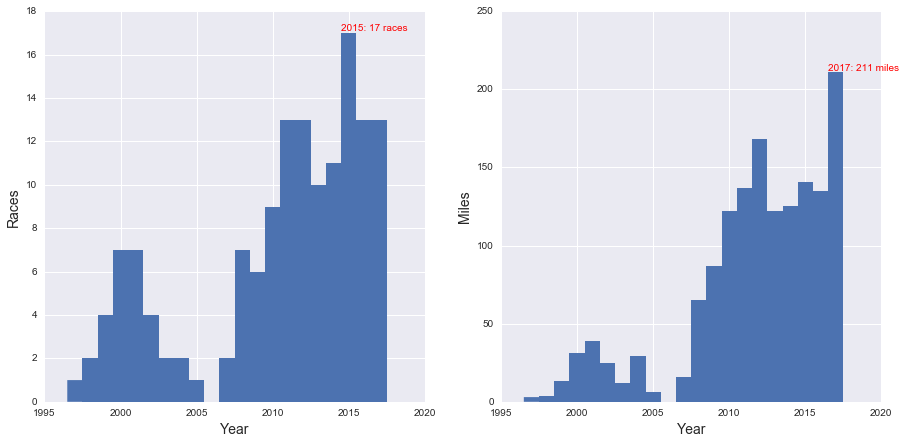

In [19]:
fig,axarr = plt.subplots(1,2,figsize=(15,7))
eps = 0.5
bins = np.arange(min(years)-eps,max(years)+eps+1,1)

for ax,data,label in zip(axarr,(years,flat_list),('races','miles')):
    histobj = ax.hist(data,bins=bins)
    ax.set_xlabel("Year",fontsize=14)
    ax.set_ylabel(label.capitalize(),fontsize=14)
    label_max(histobj,ax,label);

### Total race miles

In [27]:
print("I've run {:.0f} total miles in {:d} races.".format(run['d_mi'].sum(),len(run)))

I've run 1516 total miles in 144 races.
